In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
import torch
import sys
from models import UNet
from dataloader import get_dataloaders

In [3]:
if not os.path.exists("./checkpoint"):
    os.mkdir("checkpoint")
if not os.path.exists("./results"):
    os.mkdir("results")

In [4]:
%%bash
cp /capstor/scratch/cscs/class172/unet_d3_out1_gpu_L1_traced.pt checkpoint/
cp /capstor/scratch/cscs/class172/unet_d4_out1_gpu_L1_traced.pt checkpoint/
cp /capstor/scratch/cscs/class172/unet_d5_out1_gpu_L1_traced.pt checkpoint/
cp /capstor/scratch/cscs/class172/unet_d6_out1_gpu_L1_traced.pt checkpoint/
cp /capstor/scratch/cscs/class172/unet_d7_out1_gpu_L1_traced.pt checkpoint/

In [5]:
def gen_animation(seq, save_path):

    print("generating animation...", flush=True)
    fig = plt.figure()
    im = plt.imshow(seq[0,...], animated=True)

    def updatefig(frame):

        if (frame<seq.shape[0]-1):
            frame += 1
        else:
            frame=0
        im.set_array(seq[frame,...])
        return im,

    ani = animation.FuncAnimation(fig, updatefig,  blit=True, interval=500, frames=seq.shape[0])
    writer = animation.PillowWriter(fps=1,
                                bitrate=1000)
    ani.save(save_path, writer=writer)

(5, 320, 320)
(320, 320)
(320, 320)


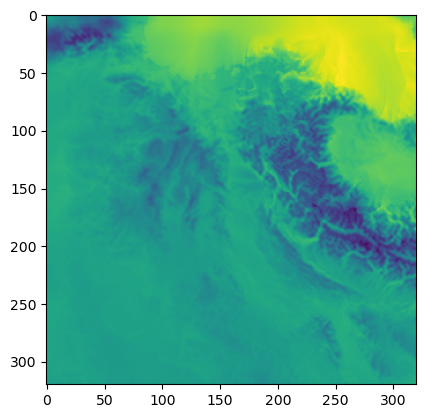

In [6]:
device = torch.device('cuda')

in_len=5
out_len=1
with torch.no_grad():
    #model = UNet(in_channels=in_len, 
    #num_classes=out_len, 
    #depth=5, merge_mode='concat').to(device)
    
    model = torch.jit.load('./checkpoint/unet_d5_out1_gpu_L1_traced.pt', map_location="cuda")
    model.eval()

    # test_loader, _ = get_dataloaders(1,
    #                             in_len=in_len,
    #                             out_len=out_len,
    #                             )

    # test_input, test_target = next(iter(test_loader))
    test_input = np.fromfile("data/input_tensor.dat", dtype=np.float32)
    input_shape = (320, 320, in_len, out_len)
    test_input = test_input.reshape(input_shape)
    test_input = test_input.transpose()
    test_target = np.fromfile("data/target_tensor.dat", dtype=np.float32)
    target_shape = (320, 320, 1, 1)
    test_target = test_target.reshape(target_shape)
    test_target = test_target.transpose()

    test_input, test_target = torch.from_numpy(test_input), torch.from_numpy(test_target) 
    test_input, test_target = test_input.to(device), test_target.to(device).float()

    test_output = model(test_input)

    test_input = test_input.squeeze().cpu().numpy()
    test_target = test_target.squeeze().cpu().numpy()
    test_output = test_output.squeeze().cpu().numpy()

    if not os.path.exists("./results"):
        os.mkdir("results")

    print(test_input.shape)
    print(test_target.shape)
    print(test_output.shape)

    plt.imshow(test_output)
    plt.savefig("./results/output.png")
    plt.imshow(test_target)
    plt.savefig("./results/ground_truth.png")

In [8]:
%%bash
export LD_LIBRARY_PATH=/users/class171/miniconda3/envs/weather-cnn/lib:/users/class171/FTorchbin/lib64:$LD_LIBRARY_PATH
make run_validate MODEL=checkpoint/unet_d5_out1_gpu_L1_traced.pt DATADIR=data

gfortran -I/users/class171/FTorchbin/include -I/users/class171/FTorchbin/include/ftorch -I/users/class171/Project/FTorch/build/modules -o validate_fortran_cuda.x validate_fortran_cuda.f90 -L/users/class171/FTorchbin/lib64 -L/user-environment/env/default/lib64 -lftorch -lcudart


f951: Warning: Nonexistent include directory '/users/class171/Project/FTorch/build/modules' [-Wmissing-include-dirs]


./validate_fortran_cuda.x checkpoint/unet_d5_out1_gpu_L1_traced.pt data
 Array written todata/output_fortran.dat
 UNet inference ran successfully


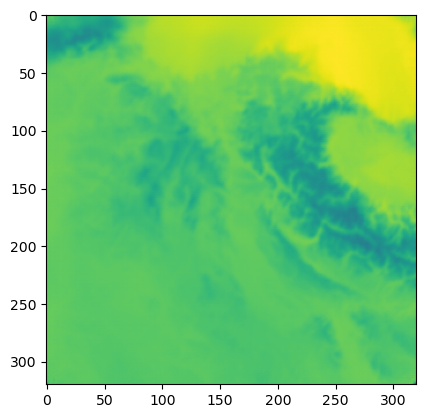

In [9]:
output_data = np.fromfile("data/output_fortran.dat", dtype=np.float32)
output_data = output_data.reshape((320,320,1,1))
output_data = output_data.transpose().squeeze()
plt.imshow(output_data)
plt.savefig("./results/fortran_output.png")